(1) **Data description**

-In this data set there are 196 observations

-There are 7 different variables. `hashed_email` and `name` have been excluded **in analysis** as they are unique to individuals and don't serve as predictors, therefore there are 5 predictive variables

`experience`: Indicates the category of skill level

`subscribe`: Indicates whether a player is subscribed (TRUE) or not (FALSE), a logical value

`hashed_email`: Indicates the players unique email, character data

`played_hours`: Indicates number of hours spent playing, a numeric value

`name`: Indicates the players name, character data

`gender`: Indicates the players gender identity, a categorical value

`age`: Indicates the players age in years, a numeric value

-There are two main issues in this data set. 
1. There is an option for players to report "prefer not to say" for gender. This could cause issues when using gender as a predictive variable as it introduces uncertainty and missing data.
2. The other issue in the data are the NA (missing data) values throughout the columns, this could lead to less accurate predictions.

   
   






In [15]:
nrow(player_data)

[1] 196

(2) **Question**

My question will investigate if age can help predict the playing time of users in the `player_csv` dataset.


This question connects to the broad question of what "kinds" of players contribute the most data to the server. It looks at the age range of users who spend the most hours playing, specifiying the "kind" of player by their age, and interpreting the most contribution of data to the server as the amount of hours spent playing. 

The `player_csv` dataset will help to answer this predictive question as it contains information about the `age` and `played_hours` . Having a large age range will help identify trends and correlations. A narrow range would cause the model to predict from a limited range of data, making it less accurate.




(3) **Exploratory Data Analysis and Visualization**

Attach needed packages

In [2]:
library(repr)
library(tidyverse)
library(tidymodels)
options(repr.matrix.max.rows = 10)
source("cleanup.R")
set.seed (2000)

── Attaching core tidyverse packages ──────────────────────── tidyverse 2.0.0 ──
✔ dplyr     1.1.4     ✔ readr     2.1.5
✔ forcats   1.0.0     ✔ stringr   1.5.1
✔ ggplot2   3.5.1     ✔ tibble    3.2.1
✔ lubridate 1.9.3     ✔ tidyr     1.3.1
✔ purrr     1.0.2     
── Conflicts ────────────────────────────────────────── tidyverse_conflicts() ──
✖ dplyr::filter() masks stats::filter()
✖ dplyr::lag()    masks stats::lag()
ℹ Use the conflicted package (<http://conflicted.r-lib.org/>) to force all conflicts to become errors
── Attaching packages ────────────────────────────────────── tidymodels 1.1.1 ──

✔ broom        1.0.6     ✔ rsample      1.2.1
✔ dials        1.3.0     ✔ tune         1.1.2
✔ infer        1.0.7     ✔ workflows    1.1.4
✔ modeldata    1.4.0     ✔ workflowsets 1.0.1
✔ parsnip      1.2.1     ✔ yardstick    1.3.1
✔ recipes      1.1.0     

── Conflicts ───────────────────────────────────────── tidymodels_conflicts() ──
✖ scales::discard() masks purrr::discard()
✖ dplyr::filt

ERROR: Error in file(filename, "r", encoding = encoding): cannot open the connection


Upload Player Data

In [4]:
player_data <- read_csv("https://raw.githubusercontent.com/bellamartens/Individual_Project/refs/heads/main/players.csv")

player_data

Rows: 196 Columns: 7
── Column specification ────────────────────────────────────────────────────────
Delimiter: ","
chr (4): experience, hashedEmail, name, gender
dbl (2): played_hours, Age
lgl (1): subscribe

ℹ Use `spec()` to retrieve the full column specification for this data.
ℹ Specify the column types or set `show_col_types = FALSE` to quiet this message.


experience,subscribe,hashedEmail,played_hours,name,gender,Age
<chr>,<lgl>,<chr>,<dbl>,<chr>,<chr>,<dbl>
Pro,TRUE,f6daba428a5e19a3d47574858c13550499be23603422e6a0ee9728f8b53e192d,30.3,Morgan,Male,9
Veteran,TRUE,f3c813577c458ba0dfef80996f8f32c93b6e8af1fa939732842f2312358a88e9,3.8,Christian,Male,17
Veteran,FALSE,b674dd7ee0d24096d1c019615ce4d12b20fcbff12d79d3c5a9d2118eb7ccbb28,0.0,Blake,Male,17
Amateur,TRUE,23fe711e0e3b77f1da7aa221ab1192afe21648d47d2b4fa7a5a659ff443a0eb5,0.7,Flora,Female,21
Regular,TRUE,7dc01f10bf20671ecfccdac23812b1b415acd42c2147cb0af4d48fcce2420f3e,0.1,Kylie,Male,21
⋮,⋮,⋮,⋮,⋮,⋮,⋮
Amateur,TRUE,b6e9e593b9ec51c5e335457341c324c34a2239531e1890b93ca52ac1dc76b08f,0.0,Bailey,Female,17
Veteran,FALSE,71453e425f07d10da4fa2b349c83e73ccdf0fb3312f778b35c5802c3292c87bd,0.3,Pascal,Male,22
Amateur,FALSE,d572f391d452b76ea2d7e5e53a3d38bfd7499c7399db299bd4fedb06a46ad5bb,0.0,Dylan,Prefer not to say,17


Wrangle data as needed

In [6]:
player_data <- rename(player_data,
                      hashed_email = hashedEmail,
                      age = Age)
player_data                 

experience,subscribe,hashed_email,played_hours,name,gender,age
<chr>,<lgl>,<chr>,<dbl>,<chr>,<chr>,<dbl>
Pro,TRUE,f6daba428a5e19a3d47574858c13550499be23603422e6a0ee9728f8b53e192d,30.3,Morgan,Male,9
Veteran,TRUE,f3c813577c458ba0dfef80996f8f32c93b6e8af1fa939732842f2312358a88e9,3.8,Christian,Male,17
Veteran,FALSE,b674dd7ee0d24096d1c019615ce4d12b20fcbff12d79d3c5a9d2118eb7ccbb28,0.0,Blake,Male,17
Amateur,TRUE,23fe711e0e3b77f1da7aa221ab1192afe21648d47d2b4fa7a5a659ff443a0eb5,0.7,Flora,Female,21
Regular,TRUE,7dc01f10bf20671ecfccdac23812b1b415acd42c2147cb0af4d48fcce2420f3e,0.1,Kylie,Male,21
⋮,⋮,⋮,⋮,⋮,⋮,⋮
Amateur,TRUE,b6e9e593b9ec51c5e335457341c324c34a2239531e1890b93ca52ac1dc76b08f,0.0,Bailey,Female,17
Veteran,FALSE,71453e425f07d10da4fa2b349c83e73ccdf0fb3312f778b35c5802c3292c87bd,0.3,Pascal,Male,22
Amateur,FALSE,d572f391d452b76ea2d7e5e53a3d38bfd7499c7399db299bd4fedb06a46ad5bb,0.0,Dylan,Prefer not to say,17


Compute average of **quantitative** values

In [27]:
avg_played_hours <- player_data |>
             summarize(avg_played_hours = mean(played_hours, na.rm = TRUE))

avg_age <- player_data |>
                summarize(avg_age = mean(age, na.rm = TRUE))
                       
avg_played_hours
avg_age

avg_played_hours
<dbl>
5.845918


avg_age
<dbl>
20.52062


Report values in a Table

| Average Hours Played | Average Age|
|---|---|
| 6 | 21 |

Visualize the data

Warning message:
“Removed 2 rows containing missing values or values outside the scale range
(`geom_point()`).”


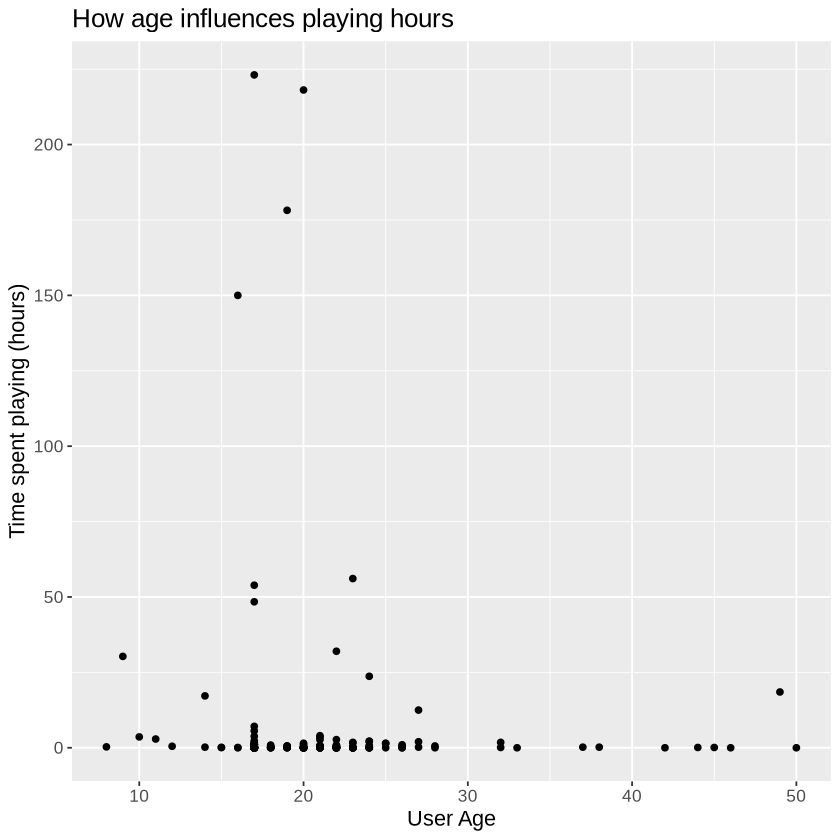

In [37]:
options(repr.plot.width = 7, repr.plot.height = 7) 

plot_1 <- player_data |>
          ggplot(aes(x = age, y = played_hours)) +
          geom_point () +
          labs(x = "User Age", y = "Time spent playing (hours)") +
          ggtitle("How age influences playing hours") +
 theme(text = element_text(size = 13))

plot_1


This scatter plot very loosely shows that ages ranging between 16-22 may have higher playing hours. These are the only ages where there are outliers with very high playing hours (150hrs+). However much of the data doesn't report playing hours for many of the ages, meaning the relationship is unable to be confirmed.

Warning message:
“Removed 2 rows containing missing values or values outside the scale range
(`geom_bar()`).”


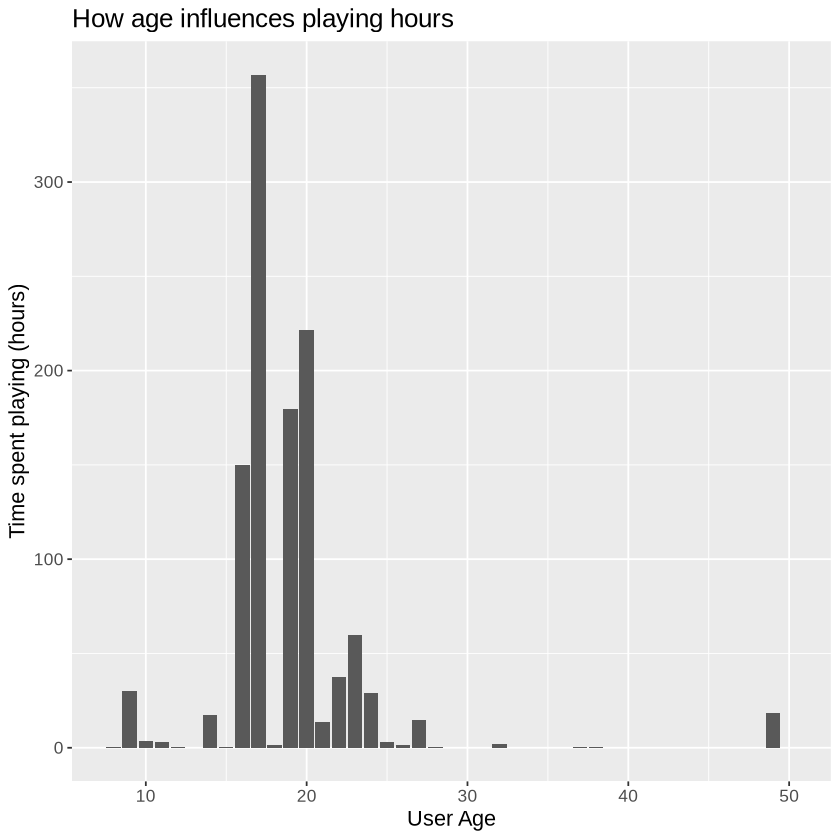

In [40]:
options(repr.plot.width = 7, repr.plot.height = 7) 


plot_2 <- player_data |>
        ggplot(aes(x = age, y = played_hours)) +
        geom_bar(stat = "identity") +
        labs(x = "User Age", y = "Time spent playing (hours)") +
        ggtitle("How age influences playing hours") +      
theme(text = element_text(size = 13))

plot_2
        

From this bar plot, we can clearly see that the ages with the highest playing hours fall between 15-20 years of age. This basic visualization already provides valuable insight into the potential relationship between the two variables by showing that 
younger people spend more time playing.

(4) **Methods and Plan**


The method that will be used to address the question will be K-nearest regression using a KNN model. 
The question is trying to investigate how a players age can predict what their playing hours will be, predicting a numerical 
value requires regression. 

This is an appropriate model to use because the data set is not overly large, we are working with only one predictor, and the range of values inputted in the training data is relatively large. However potential limitations of the model may include sensitivity to outliers which could impact distance calculations. 

The steps to investigate the data will follow the standard process. First, the data will be split into training and testing sets, storing about 80% of the data while testing on 20% of it. The data will be standardized, the model will be trained and the best K value will be chosen through cross-validation. Cross validation will occur by splitting the training data into 5 folds, and then further training and evaluating the model. Once the best K value has been selected the testing data will be evaluated with the chosen K. 